<a href="https://colab.research.google.com/github/LishaRamon/applied-ml/blob/main/HW3_Comparison_of_ML_Classification_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3: - Classification Comparison with Synthetic Data

Thought process:

1. Need to compare **6 classifiers** on **4 datasets**
3. For every dataset need to: split data → fit on train → evaluate on train and test
4. Also need to visualize the decision boundaries

The 6 classifiers are:
- Naive Bayes
- Logistic Regression
- Quadratic Discriminant Analysis(QDA)
- SVM with radial basis functions (RBF) kernel
- Decision Tree
- KNN with K=1


---

## Step 1: Importing libraries

- `numpy` and `matplotlib`
- `sklearn.datasets` for creating synthetic data
- `sklearn.model_selection` for train/test splitting
- All 6 classifier classes
- `classification_report` for evaluation

Also set a random seed so results are reproducible during every run

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# data generating
from sklearn.datasets import make_blobs, make_circles, make_moons

# split data into train/test
from sklearn.model_selection import train_test_split

# import 6 classifers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# for evaluation
from sklearn.metrics import classification_report

# setting random seed for consistent reproducibility
SEED = 42
np.random.seed(SEED)

## Step 2: Define Classifers

Each dataset needs a fresh set of classifiers so nothing carries over from a previous run. I'll wrap them in a function and call it once per dataset

In [4]:
def get_classifiers():
    #returns a fresh dict for all 6 classifiers
    return {
        'Naive Bayes':    GaussianNB(),
        'Logistic Reg':   LogisticRegression(max_iter=1000, random_state=SEED),
        'QDA':            QuadraticDiscriminantAnalysis(),
        'SVM (RBF)':      SVC(kernel='rbf', random_state=SEED),
        'Decision Tree':  DecisionTreeClassifier(random_state=SEED),
        'KNN (K=1)':      KNeighborsClassifier(n_neighbors=1),
    }

## Step 3: Decision Boundary Plot Function

Since the data is 2D, I can visualize each classifier's decision boundary by predicting the class for every point on a mesh grid, coloring the regions, then overlaying the actual data points on top

In [7]:
def plot_decision_boundaries(X, y, fitted_classifiers, dataset_name):
    """ Plots the decision boundary for each fitted classifier over the 2D data
    Param:
        x: feature array
        y: label array
        fitted_classifiers: dict of model type
        dataset_name: plot title"""

    # decision region(bkgd) colors + data points
    cmap_bg     = ListedColormap(['#FFAAAA', '#AAAAFF'])  # light red/blue regions
    cmap_points = ListedColormap(['#CC0000', '#0000CC'])  # dark red/blue dots

    # mesh grid over feature space
    h = 0.05  # step size (smaller = finer grid;slower to render)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    # 1 subplot per classifier= shape( 2 rows x 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()
    fig.suptitle(f'Decision Boundaries — {dataset_name}', fontsize=14, fontweight='bold')

#loop picks next subplot+classifer together
    for ax, (name, clf) in zip(axes, fitted_classifiers.items()): #
        # predict class for every grid point — fills in the colored regions
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) #asks classifier to predict class for each point and flatten the 2D grid into a long list of x and y coordinates
        Z = Z.reshape(xx.shape) #puts predictions into 2D grid shapefor color

        # fill decision area w color
        ax.contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.5)

        # plot points on top
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_points,
                   edgecolors='k', s=25, linewidth=0.4)

        ax.set_title(name, fontsize=11)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

## Step 4: Generate Dataset 1

Need to create a dataset where all classifiers do well(near-perfect classification)

If the two classes are far apart with tight clusters then even a straight line (logistic regression) can separate them perfectly.
Will use `make_blobs`

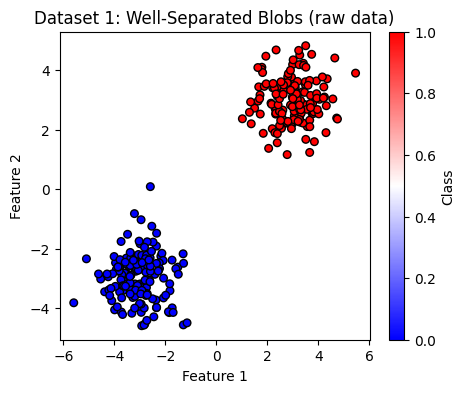

Dataset shape: (300, 2), Classes: [0 1]


In [8]:
# two blobs placed far apart in feature space
X1, y1 = make_blobs(
    n_samples=300,
    centers=[[-3, -3], [3, 3]],  # centers far apart
    cluster_std=0.8,              # slow spread, blobs tight, not spread out
    random_state=SEED
)

#scatter plot to check if it looks right before running classifiers
plt.figure(figsize=(5, 4))
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='bwr', edgecolors='k', s=30)
plt.title('Dataset 1: Well-Separated Blobs (raw data)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.show()

print(f'Dataset shape: {X1.shape}, Classes: {np.unique(y1)}')

## Step 5: Split Dataset 1 into Train and Test

Need to split data, will use 70% for training and 30% for testing

**need to remember:** never fit a model on test data. The test set is only used to evaluate after fitting on the training set.

In [9]:
# split: 70% train 30% test
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.3, random_state=SEED
)

print(f'Training samples: {len(X1_train)}')
print(f'Testing samples:  {len(X1_test)}')

Training samples: 210
Testing samples:  90


## Step 6: Fitting and Classification reports on Dataset 1

For each classifier on D1:
1. **Fit** on training data only (model never sees test data during training)
2. **Evaluate training data performance** — check for model fit/memorization
3. **Evaluate test data performance**

The `classification_report` prints precision, recall, f1-score, and accuracy for each class

In [10]:
#call 'fresh' classifiers
clf1_fitted = {}

for name, clf in get_classifiers().items():

    # part1: fit only on training data
    clf.fit(X1_train, y1_train)

    # part2: predict on training data (shows how well the model learned the training set)
    y1_train_pred = clf.predict(X1_train)

    # part3: predict on test data (shows how well the model generalizes to unseen data)
    y1_test_pred = clf.predict(X1_test)

    print(f"\n{'='*55}")
    print(f'  Classifier: {name}')
    print(f"{'='*55}")

    # part4: classification report for training
    print('\n>> Training evaluation (fit on train, predict on train):')
    print(classification_report(y1_train, y1_train_pred, zero_division=0))

    # part5: classification report for testing
    print('>> Testing evaluation (fit on train, predict on test):')
    print(classification_report(y1_test, y1_test_pred, zero_division=0))

    # saving fitted model to use for boundary plotting below
    clf1_fitted[name] = clf


  Classifier: Naive Bayes

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00       107

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210

>> Testing evaluation (fit on train, predict on test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        43

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90


  Classifier: Logistic Reg

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           

## Step 7: Visualize Decision Boundaries for Dataset 1

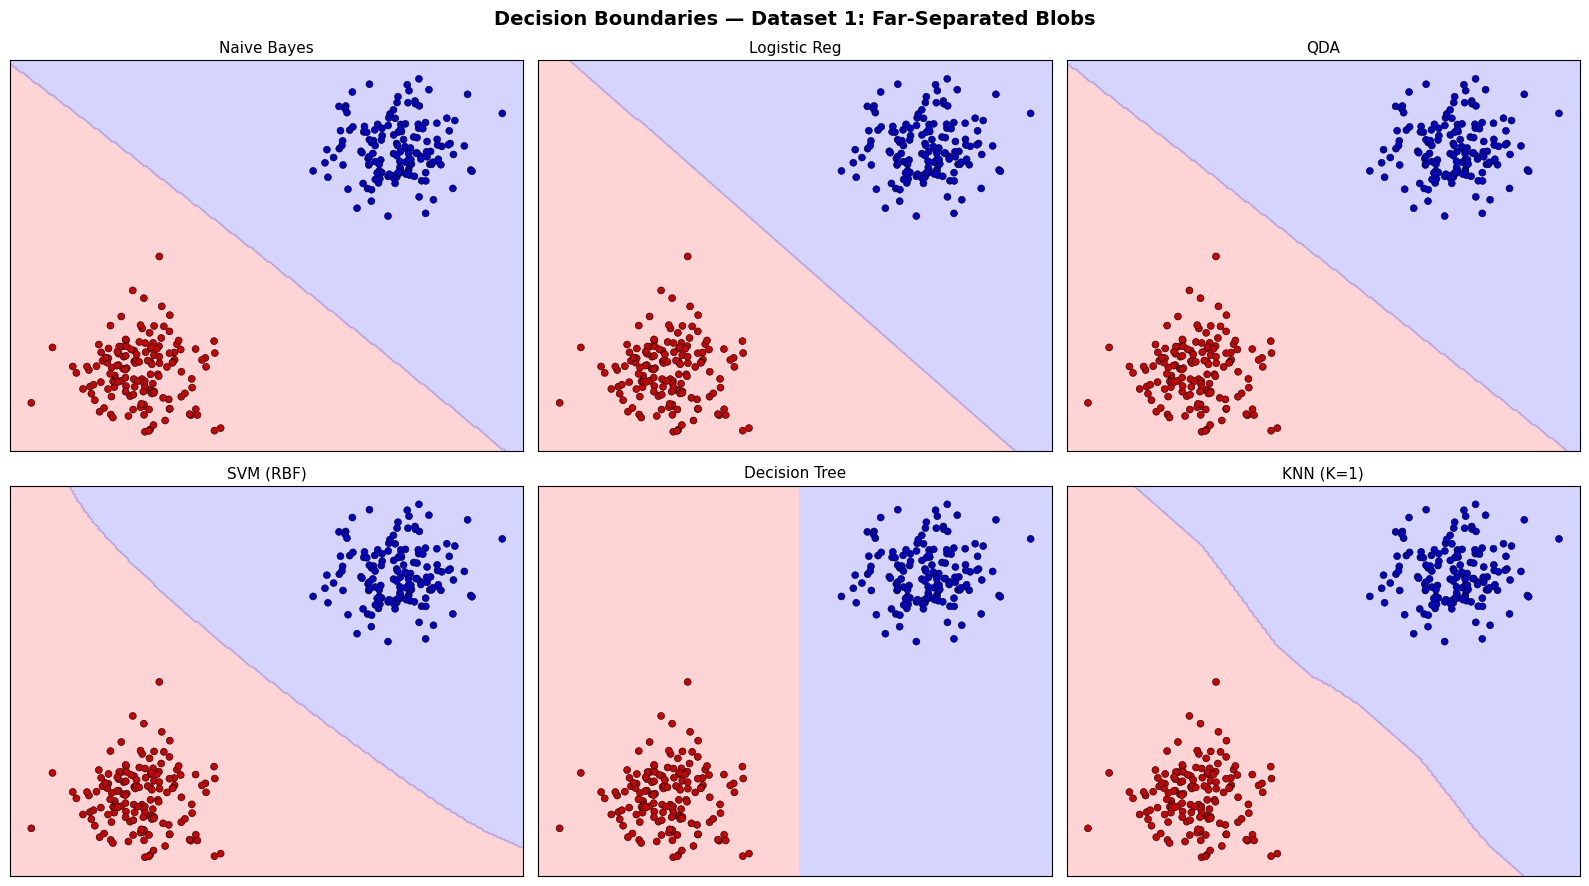

In [11]:
plot_decision_boundaries(X1, y1, clf1_fitted, 'Dataset 1: Far-Separated Blobs')

## Observed - Dataset 1

**Result:** All 6 classifiers showed near-perfect on both train and test sets

**Reason:** The clusters are widely separated with no overlap. Logistic Regression easily finds a linear boundary, while KNN and Decision Trees create more complex, jagged boundaries. Because of the clear "empty space" between classes, even the simplest model separates them perfectly
